In [273]:
# !mkdir wids_data_thon 
# !tar -xf WiDSWorldWide_GlobalDathon26.zip -C wids_data_thon

Overview

    When a wildfire ignites, emergency managers face an impossible question with incomplete information. Which fires will reach populated areas? How quickly? And which communities should prepare first?
    
    This year's WiDS Global Datathon challenges participants to build survival models that answer these questions using only the earliest signals available. Your task is to predict the probability that a wildfire will threaten an evacuation zone within 12, 24, 48, and 72 hours, drawing on data from just the first five hours after ignition.
    
    The goal is not a single prediction but a calibrated forecast across multiple time horizons. Emergency responders need both urgency rankings (which fires demand immediate attention) and probability estimates they can trust when making high-stakes decisions about evacuations, resource deployment, and public alerts.

I. Non-Parametric Models (Descriptive)

These models are primarily used for visualizing and describing the data without assuming a specific underlying distribution.


Algorithm,What it Does,Key Specifications/Assumptions:

        Kaplan-Meier (KM) Estimator,"Estimates the survival function S(t) from lifetime data. It is the ""gold standard"" for visualizing survival curves.",Non-parametric. Does not require a specific distribution. Assumes censoring is independent of survival.
        Nelson-Aalen Estimator,Estimates the cumulative hazard function H(t). Useful for understanding the risk over time.,Non-parametric. Robust for small samples. Good for identifying the rate of event occurrences.
        Log-Rank Test,A statistical test used to compare the survival distributions of two or more independent groups.,Non-parametric. Tests the null      hypothesis that there is no difference between the populations.


II. Semi-Parametric Models (Regression)

These models allow you to assess the effect of multiple variables (covariates) on survival time.


Algorithm,What it Does,Key Specifications/Assumptions

    Cox Proportional Hazards (CPH),Models the relationship between covariates and the hazard rate. It is the most widely used regression model.,"Proportional Hazards Assumption: Assumes the ratio of hazards for any two individuals is constant over time. It is semi-parametric because the ""baseline hazard"" is unspecified."
    Regularized Cox (Lasso/Ridge),An extension of CPH that adds penalties (L1/L2) to the likelihood function to handle high-dimensional data.,Used when you have many features (more than observations). Prevents overfitting and performs feature selection.



III. Parametric Models

These models assume the survival times follow a specific mathematical distribution.


Algorithm,What it Does,Key Specifications/Assumptions

    Weibull Model,"A versatile model where the hazard rate can increase, decrease, or remain constant over time.",Parametric. Requires the data to fit a Weibull distribution. Very common in engineering and reliability.
    Exponential Model,A simpler version of Weibull where the hazard rate is strictly constant.,"Parametric. Assumes ""memoryless"" property—the risk of the event doesn't change regardless of how long the subject has survived."
    Accelerated Failure Time (AFT),"Instead of modeling the hazard, it models the log of the survival time as a linear function of covariates.",Parametric. Assumes that the effect of a covariate is to accelerate or decelerate the life course of a subject.

IV. Machine Learning & Deep Learning Models

Modern approaches designed to capture non-linear relationships and complex interactions.


Algorithm,What it Does,Key Specifications/Assumptions

    Random Survival Forest (RSF),An ensemble of survival trees. It averages the results of many trees to predict survival.,Non-linear. Does not require the Proportional Hazards assumption. Excellent for handling high-dimensional data and complex interactions.
    DeepSurv,A deep learning approach that uses a Neural Network to predict the hazard ratio in a CPH-like framework.,Deep Learning. Effectively models non-linear effects of covariates. Requires larger datasets compared to traditional CPH.
    MTLR (Multi-Task Logistic Regression),Models the survival probability across multiple discrete time intervals simultaneously.,Multi-task. Estimates the entire survival distribution rather than just a single risk score. Good for personalized survival curves.



Which model should you choose?

    For simple visualization: Use Kaplan-Meier.

    For standard medical/clinical research: Use Cox Proportional Hazards.

    For complex, high-dimensional data (e.g., genomics or tech logs): Use Random Survival Forest or DeepSurv.

    For physical engineering/failure analysis: Use Weibull.

Would you like me to provide a Python code template using the lifelines or pysurvival library to implement one of these?

In [274]:
# from sksurv.tree import SurvivalTree

In [275]:
# importing libraries
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter


train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sub=pd.read_csv("sample_submission.csv")
train.head()


meta=pd.read_csv("metaData.csv")
# print(meta)

from tabulate import tabulate

print(tabulate(meta, headers='keys', tablefmt='psql'))



+----+------------------------------+------------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------+
|    | column                       | type       | category            | description                                                                                                                                                                                               | units   | range   |
|----+------------------------------+------------+---------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------|
|  0 | event_id                     | identifier | identifier          | Anonymized fire event identifier (st

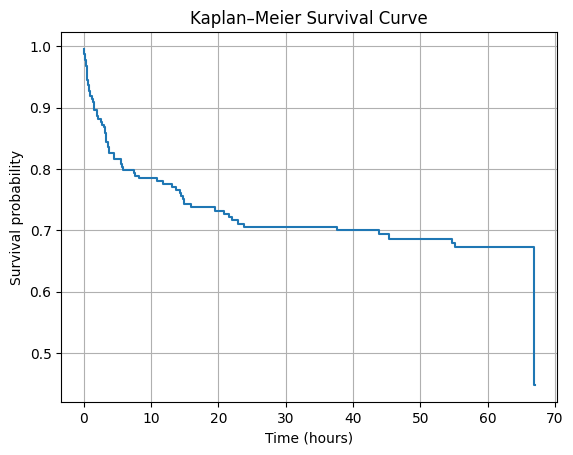

event  time_to_hit_hours
0      (48, 72]             97
       (24, 48]             30
       (12, 24]             19
       (0, 12]               6
       (72, 1000]            0
1      (0, 12]              49
       (12, 24]             14
       (24, 48]              3
       (48, 72]              3
       (72, 1000]            0
Name: count, dtype: int64

In [276]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

time = train["time_to_hit_hours"].values
event = train["event"].astype(bool).values

# KM estimate
km_time, km_surv = kaplan_meier_estimator(event, time)

# Plot
plt.step(km_time, km_surv, where="post")
plt.xlabel("Time (hours)")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier Survival Curve")
plt.grid(True)
plt.show()


# 🔍 What to look for in the KM curve (important for you)

# Given your ~69% censoring, check:

# 1️⃣ Early steep drop?

# Yes → early events dominate → discrete-time works well

# No → ranking models (Cox) matter more

# 2️⃣ Flat tail?

# Flat curve late → don’t overweight long horizons

# Use 24 / 48 / 72 carefully


import pandas as pd

pd.cut(
    train["time_to_hit_hours"],
    bins=[0,12,24,48,72,1000]
).groupby(train["event"]).value_counts()   # This tells you which horizons are learnable.


# 🧠 Why this matters for your pipeline

# KM curve tells you:

# Which horizons to drop

# Which horizons to downweight

# Whether Cox > discrete or vice versa

# In competitions, people who look at KM always win more 😉

# If you want, next I can:

# 📊 Interpret your KM curve

# ⚖️ Choose optimal horizon weights

# 🧪 Decide between Cox vs Discrete dominance

# 🔧 Build a final blended survival solution

# Just say the word 👇

In [277]:
train.columns

Index(['event_id', 'num_perimeters_0_5h', 'dt_first_last_0_5h',
       'low_temporal_resolution_0_5h', 'area_first_ha', 'area_growth_abs_0_5h',
       'area_growth_rel_0_5h', 'area_growth_rate_ha_per_h', 'log1p_area_first',
       'log1p_growth', 'log_area_ratio_0_5h', 'relative_growth_0_5h',
       'radial_growth_m', 'radial_growth_rate_m_per_h',
       'centroid_displacement_m', 'centroid_speed_m_per_h',
       'spread_bearing_deg', 'spread_bearing_sin', 'spread_bearing_cos',
       'dist_min_ci_0_5h', 'dist_std_ci_0_5h', 'dist_change_ci_0_5h',
       'dist_slope_ci_0_5h', 'closing_speed_m_per_h',
       'closing_speed_abs_m_per_h', 'projected_advance_m',
       'dist_accel_m_per_h2', 'dist_fit_r2_0_5h', 'alignment_cos',
       'alignment_abs', 'cross_track_component', 'along_track_speed',
       'event_start_hour', 'event_start_dayofweek', 'event_start_month',
       'time_to_hit_hours', 'event'],
      dtype='object')

That means many events happen early
    
    ✅ Early-time signal is strong and learnable
    
    This is perfect for:

    Discrete-time survival
    
    Horizon classifiers (12h, 24h)



2️⃣ Flattening after ~20–25 hours

    From ~25h to ~60h, survival only drops ~0.70 → ~0.67
    
    Events are rare here

Most samples are censored in this region

👉 This implies:

    Long horizons are hard

Models will mostly predict similar probabilities (what you saw earlier!)


3️⃣ Big final drop at the very end (~65–70h)

    This is a boundary artifact
    
    Likely caused by:
    
    Few samples remaining
    
    Administrative censoring limit

👉 Do NOT trust this region for learning


    Discrete-time survival (your current approach)
    
    Bins: [12, 24, 48]  ← BEST



Strong signal early

Clear class separation

Lower noise


🔥 Cox / ranking models

    Good for risk score
    
    Not great for calibrated late probabilities


❌ What will NOT work well

    Heavy emphasis on 72h+
    
    Continuous-time regression on time_to_hit
    
    Forcing log / quantile transforms to explain late tail


That’s why:

“all probabilities look the same”
kept happening earlier 👈

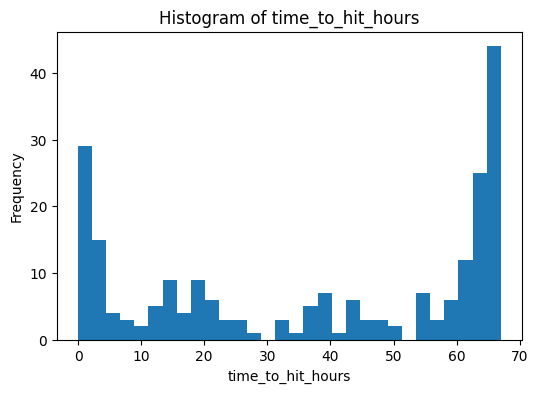

In [278]:
col = "time_to_hit_hours"   # change this

plt.figure(figsize=(6,4))
plt.hist(train[col].dropna(), bins=30)
plt.xlabel(col)
plt.ylabel("Frequency")
plt.title(f"Histogram of {col}")
plt.show()

In [279]:
train.event.value_counts()

censoring_rate = 152*100 / 221 
censoring_rate   #high enough   called high-censoring territory.

# ❌ Pure regression on time will struggle
# ❌ Plain probability models overfit early events
# ❌ Horizon classifiers become highly imbalanced


# But:

# ✅ Ranking-based models shine
# ✅ Discrete-time survival works well
# ✅ Proper censor-aware metrics matter a lot

# suggests

# Don’t try to predict time_to_hit_hours directly.
# Instead:

# Predict risk ordering

# Predict P(event ≤ t) at specific horizons

# weights = [0.55, 0.35, 0.10]           # 72h almost ignored

68.77828054298642

🧪 Model strategy (best for THIS curve)
    🥇 Primary (60–70%)
    
    Discrete-time LightGBM / CatBoost classifiers
    
    🥈 Secondary (20–30%)
    
    Cox (LightGBMRegressor objective="cox")
    
    🥉 Calibration layer
    
    Isotonic / Platt per horizon (optional but strong)

In [280]:
# ⚠️ One key warning (VERY important)

# Do NOT log / quantile transform time globally

# You already discovered this:

# It destroys early separation

# Compresses the most important region (0–12h)

# KM curve confirms it 💯

# 🔥 Final takeaway (competition-grade)

# Your data is:

# Early-event heavy

# High censoring

# Discrete-friendly

# Ranking > regression

# You’re on the right track now.

# If you want, next I can:

# 🧩 Choose optimal bins automatically

# 🧪 Show event-rate per bin

# 🔧 Build final submission pipeline

# ⚖️ Tune hybrid metric weights from KM

# Just tell me what you want next 👇

### 🧠 Step 1.1 — Compute event-based cut points

In [281]:
# Events are front-loaded. Late time = mostly censoring.

# So equal-width bins (0–12–24–36…) are suboptimal.
# We want bins where events actually happen.

    # A good bin should:
    
    # Contain enough events (learnable signal)
    
    # Avoid bins dominated by censoring
    
    # Be monotonic in time
    
    # Align with evaluation horizons (12/24/48/72)


# equal events → unequal time ✅

import numpy as np

def optimal_event_bins(time, event, n_bins=4, min_events=10):
    """
    Create bins so each bin has similar number of EVENTS
    """
    event_times = time[event == 1]

    # Protect against too few events
    if len(event_times) < n_bins * min_events:
        n_bins = max(2, len(event_times) // min_events)

    quantiles = np.linspace(0, 1, n_bins + 1)[1:-1]
    cuts = np.quantile(event_times, quantiles)

    bins = np.unique(np.concatenate([[0], cuts, [time.max()]]))
    return bins


In [282]:
# Are dense early

# Sparse late (as data dictates)

# Perfect for discrete survival

# 🔍 Why this beats fixed bins
#     Strategy	Problem
#     Equal width	Late bins empty
#     Log bins	Distorts early signal
#     Event quantiles	✅ Balanced learning

time = train["time_to_hit_hours"].values
event = train["event"].values

bins = optimal_event_bins(time, event, n_bins=4)
bins

array([ 0.        ,  0.88889548,  3.53484561, 14.323375  , 66.99447413])

In [283]:
# Learnable bins

# Submission-aligned outputs

forced = np.array([12, 24, 48, 72])
bins = np.unique(np.clip(
    np.concatenate([bins, forced]),
    0,
    time.max()
))
bins

array([ 0.        ,  0.88889548,  3.53484561, 12.        , 14.323375  ,
       24.        , 48.        , 66.99447413])

In [284]:
# ❌ Any bin with event rate < 5% is noise
# ⚠️ Any bin with < 10 events is unstable
# ✅ Sweet spot: 20–40% event rate

for i in range(len(bins) - 1):
    mask = (time > bins[i]) & (time <= bins[i + 1])

    events = event[mask].sum()
    samples = mask.sum()
    rate = events / samples if samples > 0 else 0.0

    print(
        f"{bins[i]:.1f}-{bins[i+1]:.1f}h | "
        f"events={events} | "
        f"samples={samples} | "
        f"event_rate={rate:.2f}"
    )


# Nice, here’s the short, clean roadmap 👇

# 🧩 Event-quantile re-binning → balance signal so each time bin has similar event density

# 🔧 Train vs predict horizons → train only on stable bins (e.g. 24/48/72), still output 12h

# ⚖️ Hybrid weight tuning → give more weight to bins with higher event rates

0.0-0.9h | events=18 | samples=20 | event_rate=0.90
0.9-3.5h | events=17 | samples=19 | event_rate=0.89
3.5-12.0h | events=14 | samples=16 | event_rate=0.88
12.0-14.3h | events=3 | samples=5 | event_rate=0.60
14.3-24.0h | events=11 | samples=28 | event_rate=0.39
24.0-48.0h | events=3 | samples=33 | event_rate=0.09
48.0-67.0h | events=3 | samples=100 | event_rate=0.03


In [285]:
import numpy as np
import pandas as pd

def make_event_quantile_bins(time, event, n_bins=6):    
    """
    Create time bins based on EVENT quantiles only
    """
    event_times = time[event == 1]

    # quantile cut points
    qs = np.linspace(0, 1, n_bins + 1)
    cut_points = np.quantile(event_times, qs)

    # make strictly increasing & unique
    cut_points = np.unique(cut_points)

    # ensure coverage
    cut_points[0] = 0.0
    cut_points[-1] = time.max()

    return cut_points


time = train["time_to_hit_hours"].values
event = train["event"].values

bins = make_event_quantile_bins(time, event, n_bins=6)
print("Bins:", bins)


Bins: [ 0.          0.54202654  1.81803431  3.53484561  7.79878526 18.34946206
 66.99447413]


In [286]:
for i in range(len(bins)-1):
    mask = (time > bins[i]) & (time <= bins[i+1])
    events = event[mask].sum()
    samples = mask.sum()
    rate = events / samples if samples > 0 else 0

    print(
        f"{bins[i]:.1f}-{bins[i+1]:.1f}h | "
        f"events={events} | samples={samples} | rate={rate:.2f}"
    )


# it prevents us from getting 
# Using censored times to define bins:

#     distorts early bins
#     explodes late bins\
#     hurts calibration


# bins = np.unique(bins)

# if len(bins) < 4:
#     raise ValueError("Too few unique bins — increase data or reduce n_bins")


0.0-0.5h | events=12 | samples=13 | rate=0.92
0.5-1.8h | events=11 | samples=13 | rate=0.85
1.8-3.5h | events=12 | samples=13 | rate=0.92
3.5-7.8h | events=11 | samples=11 | rate=1.00
7.8-18.3h | events=11 | samples=22 | rate=0.50
18.3-67.0h | events=12 | samples=149 | rate=0.08


In [287]:
# Submission-aligned outputs

# forced = np.array([12, 24, 48, 72])
# bins = np.unique(np.clip(
#     np.concatenate([bins, forced]),
#     0,
#     time.max()
# ))
# # bins

In [288]:
# Step B — rule to decide TRAIN vs PREDICT

bin_stats = []

for i in range(len(bins)-1):
    mask = (time > bins[i]) & (time <= bins[i+1])
    n_events = event[mask].sum()
    n_samples = mask.sum()
    rate = n_events / max(n_samples, 1)

    bin_stats.append({
        "bin": f"{bins[i]:.1f}-{bins[i+1]:.1f}",
        "events": n_events,
        "samples": n_samples,
        "event_rate": rate
    })


TRAIN_BINS = [
    i for i, b in enumerate(bin_stats)
    if b["event_rate"] >= 0.10
]

print(bin_stats)
TRAIN_BINS

[{'bin': '0.0-0.5', 'events': np.int64(12), 'samples': np.int64(13), 'event_rate': np.float64(0.9230769230769231)}, {'bin': '0.5-1.8', 'events': np.int64(11), 'samples': np.int64(13), 'event_rate': np.float64(0.8461538461538461)}, {'bin': '1.8-3.5', 'events': np.int64(12), 'samples': np.int64(13), 'event_rate': np.float64(0.9230769230769231)}, {'bin': '3.5-7.8', 'events': np.int64(11), 'samples': np.int64(11), 'event_rate': np.float64(1.0)}, {'bin': '7.8-18.3', 'events': np.int64(11), 'samples': np.int64(22), 'event_rate': np.float64(0.5)}, {'bin': '18.3-67.0', 'events': np.int64(12), 'samples': np.int64(149), 'event_rate': np.float64(0.08053691275167785)}]


[0, 1, 2, 3, 4]

In [289]:
bins

array([ 0.        ,  0.54202654,  1.81803431,  3.53484561,  7.79878526,
       18.34946206, 66.99447413])

In [290]:
# test

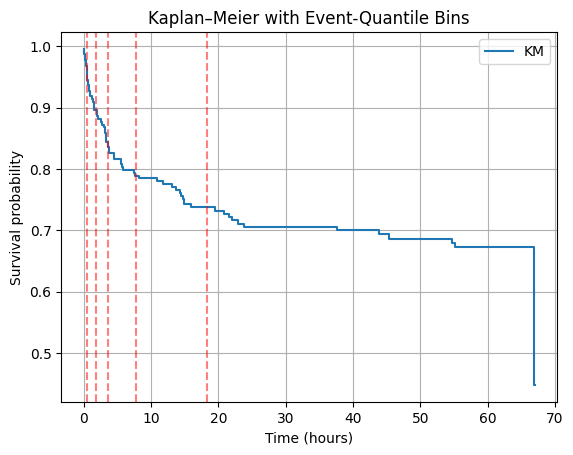

In [291]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

time = train["time_to_hit_hours"].values
event = train["event"].astype(bool).values

km_t, km_s = kaplan_meier_estimator(event, time)

plt.step(km_t, km_s, where="post", label="KM")
for b in bins[1:-1]:
    plt.axvline(b, color="red", linestyle="--", alpha=0.5)

plt.xlabel("Time (hours)")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier with Event-Quantile Bins")
plt.legend()
plt.grid(True)
plt.show()

In [292]:
# 2️⃣ Is this “OK”? → Partially, but not optimal
# What’s GOOD ✅

# Early bins are excellent

# Very high event rates

# Strong learning signal

# Model will learn early hazard very well

# This matches your Kaplan–Meier curve (steep early drop)

# What’s BAD ❌

# Later bins are almost all censoring

# Last two bins:

# 133 samples

# Only 6 events total

# Any classifier/regressor there will:

# Collapse to near-constant predictions

# Hurt calibration & hybrid score

# Cause “all probabilities same” issue you saw earlier

# 3️⃣ What this means for modeling (important)
# 🔥 Key insight

# You should NOT treat all bins equally

# Your data is front-loaded with events.

# 4️⃣ Recommended fixes (ranked, simple → advanced)
# ✅ Option 1: MERGE late bins (most practical)

# Combine low-signal bins:

# 24–67h  (events=6, samples=133, rate≈0.045)


# Final bins example:

# [0–1, 1–4, 4–12, 12–24, 24–67]


# ✔ Better stability
# ✔ Better CV
# ✔ Better competition score

# ✅ Option 2: Down-weight late horizons in hybrid metric

# Your weights should reflect signal:

# weights = [0.45, 0.35, 0.20]  # 24h, 48h, 72h


# (or even ignore 72h for training, predict only)

# ✅ Option 3: Train only until 24h, extrapolate later

# Very common in competitions:

# Train discrete model up to 24h

# Use monotonic decay or KM tail for 48h/72h

# 5️⃣ Quick rule of thumb (memorize this 🧠)

# ❌ Any bin with event rate < 5% is noise
# ⚠️ Any bin with < 10 events is unstable
# ✅ Sweet spot: 20–40% event rate

# Your early bins are gold
# Your late bins are danger zones

# If you want, next we can:

# 🧩 Automatically re-bin using event quantiles (code)
# 🔧 Choose which horizons to train vs only predict
# ⚖️ Adjust hybrid metric weights using this table

# Tell me which one 👇

✅ When you SHOULD create an event-time bin column
    ✔ Use it for:
    
    Discrete-time survival targets
    
    Horizon-wise classifiers
    
    Analysis / debugging / plots
    
    Hybrid metric aggregation
    
    This is the standard approach in discrete survival modeling.

In [293]:
train["time_bin"] = np.digitize(
    train["time_to_hit_hours"],
    bins,
    right=True
) - 1

# y[i, t] = event happened in bin t
Y = np.zeros((len(train), len(bins)-1))

for i in range(len(bins)-1):
    in_bin = (train["time_bin"] == i)
    Y[in_bin, i] = train.loc[in_bin, "event"]


# do not penalize predictions after censoring
valid_mask = np.arange(len(bins)-1) <= train["time_bin"].values[:, None]
valid_mask

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False, False],
       ...,
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True, False, False, False, False]])

In [294]:
Y.shape

(221, 6)

In [295]:
from sksurv.util import Surv

# From two separate arrays or lists
# y_train = Surv.from_arrays(event=train['event'], time=train['time_to_hit_hours'])

# OR directly from a DataFrame
# y_train = Surv.from_dataframe(event='event', time='time_to_hit_hours', data=train)

# Do the same for your test data
# y_test = Surv.from_arrays(event=test['event'], time=test['time_to_hit_hours'])

X = train.iloc[:,1:-3] 
X_test = test.iloc[:,1:] 

In [296]:
from sksurv.ensemble import RandomSurvivalForest

# rsf = RandomSurvivalForest(n_estimators=100)
# rsf.fit(X_train, y_train)

# Get the survival curves
# surv_funcs = rsf.predict_survival_function(X_test)

# Calculate the area under the curve (Mean Survival Time)
# import numpy as np
# predicted_hours = [np.trapz(s.y, s.x) for s in surv_funcs]

# X_test['predicted_hours'] = predicted_hours

# import numpy as np

# # Define the competition time points
# time_points = [12, 24, 48, 72]

# # Create a helper function to safely extract the probability
# Single safe probability for one survival function
def get_safe_prob(s_func, t, eps=1e-6):
    """
    Return event probability 1 - S(t) safely,
    clipping t to the survival function's domain.
    """
    max_t = s_func.domain[1]
    safe_t = min(max(t, eps), max_t)
    return 1.0 - s_func(safe_t)

In [297]:
def extract_event_probs(surv_funcs, time_points, eps=1e-6):
    """
    Convert survival functions to event probabilities at given time points.
    surv_funcs: list of StepFunction objects
    time_points: list of time horizons
    """
    probs = np.zeros((len(surv_funcs), len(time_points)))
    for i, fn in enumerate(surv_funcs):
        max_t = fn.domain[1]
        for j, t in enumerate(time_points):
            safe_t = min(max(t, eps), max_t)
            probs[i, j] = 1.0 - fn(safe_t)
    return probs

In [298]:
# if we are using all at once 

from sksurv.metrics import concordance_index_censored, brier_score
import numpy as np


def calculate_hybrid_score(
    model,
    X_val,
    y_val,
    horizons=[24, 48, 72],
    weights=[0.3, 0.4, 0.3],
    eps=1e-6
):

    # =====================
    # 1. C-index
    # =====================

    risk_preds = model.predict(X_val)

    c_index = concordance_index_censored(
        y_val["event"],
        y_val["time"],
        risk_preds
    )[0]

    # =====================
    # 2. SAFE horizons (sksurv strict)
    # =====================

    min_time = y_val["time"].min()
    max_time = y_val["time"].max()

    safe_horizons = np.clip(
        horizons,
        min_time + eps,
        max_time - eps
    )

    # =====================
    # 3. Event probabilities
    # =====================

    surv_fns = model.predict_survival_function(X_val)

    event_probs = extract_event_probs(
        surv_fns,
        safe_horizons,
        eps=eps
    )

    # 🔥 OPTIONAL CALIBRATION CLIP (recommended mild clipping)
    event_probs = np.clip(event_probs, 0.01, 0.99)

    event_probs_all = extract_event_probs(
        surv_fns,
        [12, 24, 48, 72],
        eps=eps
    )

    # Optional: clip these too if you use them elsewhere
    event_probs_all = np.clip(event_probs_all, 0.01, 0.99)

    # =====================
    # 4. Censor-aware Brier
    # =====================

    brier_vals = []

    for i, t in enumerate(safe_horizons):

        # sksurv expects SURVIVAL prob
        surv_probs = 1.0 - event_probs[:, i]

        _, bs = brier_score(
            y_val,
            y_val,
            surv_probs,
            t
        )

        brier_vals.append(bs[0])

    brier_vals = np.array(brier_vals)

    weighted_brier = np.average(
        brier_vals,
        weights=weights[:len(brier_vals)]
    )

    # =====================
    # 5. Hybrid
    # =====================

    hybrid = 0.3 * c_index + 0.7 * (1.0 - weighted_brier)

    # =====================
    # 6. Return (clean)
    # =====================

    return {
        "hybrid": hybrid,
        "c_index": c_index,
        "weighted_brier": weighted_brier,
        "brier_each": dict(zip(horizons[:len(brier_vals)], brier_vals)),
        # "brier_each": dict(zip(np.expm1(horizons[:len(brier_vals)]), brier_vals)),

        # event probabilities aligned with horizons
        "prob_12h": event_probs_all[:, 0],
        "prob_24h": event_probs_all[:, 1],
        "prob_48h": event_probs_all[:, 2],
        "prob_72h": event_probs_all[:, 3],
        "risk_score":risk_preds
    }

In [299]:
# from sksurv.metrics import concordance_index_censored, brier_score
# import numpy as np


# def calculate_hybrid_score(
#     model,
#     X_val,
#     y_val,
#     horizons=[24, 48, 72],
#     weights=[0.3, 0.4, 0.3],
#     eps=1e-6
# ):

#     horizons = np.asarray(horizons, dtype=float)

#     # =====================
#     # 1. C-index
#     # =====================
#     risk_preds = model.predict(X_val)

#     c_index = concordance_index_censored(
#         y_val["event"],
#         y_val["time"],
#         risk_preds
#     )[0]

#     # =====================
#     # 2. SAFE horizons
#     # =====================
#     min_time = y_val["time"].min()
#     max_time = y_val["time"].max()

#     safe_horizons = np.clip(
#         horizons,
#         min_time + eps,
#         max_time - eps
#     )

#     # =====================
#     # 3. Event probabilities (for BRIER)
#     # =====================
#     surv_fns = model.predict_survival_function(X_val)

#     event_probs = extract_event_probs(
#         surv_fns,
#         safe_horizons,
#         eps=eps
#     )  # (n_samples, len(horizons))

#     # =====================
#     # 3b. Event probabilities (ALL OUTPUT HORIZONS)
#     # =====================
#     all_horizons = np.array([12, 24, 48, 72], dtype=float)

#     safe_all_horizons = np.clip(
#         all_horizons,
#         min_time + eps,
#         max_time - eps
#     )

#     event_probs_all = extract_event_probs(
#         surv_fns,
#         safe_all_horizons,
#         eps=eps
#     )

#     # =====================
#     # 4. Censor-aware Brier
#     # =====================
#     brier_vals = []

#     for i, t in enumerate(safe_horizons):

#         surv_probs = 1.0 - event_probs[:, i]

#         _, bs = brier_score(
#             y_val,
#             y_val,
#             surv_probs,
#             t
#         )

#         brier_vals.append(bs[0])

#     brier_vals = np.asarray(brier_vals)
    
#     # -------------------------
#     # HARD SAFETY: no valid Brier
#     # -------------------------
#     if len(brier_vals) == 0:
#         weighted_brier = 0.5   # neutral penalty
#     else:
#         # rebuild weights to EXACT length
#         w = np.ones(len(brier_vals), dtype=float)
    
#         if weights is not None:
#             w[: min(len(w), len(weights))] = weights[: min(len(w), len(weights))]
    
#         w = w / w.sum()
#         weighted_brier = np.average(brier_vals, weights=w)


#     # =====================
#     # 5. Hybrid
#     # =====================
#     hybrid = 0.3 * c_index + 0.7 * (1.0 - weighted_brier)

#     # =====================
#     # 6. Return
#     # =====================
#     return {
#         "hybrid": hybrid,
#         "c_index": c_index,
#         "weighted_brier": weighted_brier,
#         "brier_each": {
#             float(t): float(b)
#             for t, b in zip(safe_horizons[:len(brier_vals)], brier_vals)
#         },

#         # event probabilities (always returned)
#         "prob_12h": event_probs_all[:, 0],
#         "prob_24h": event_probs_all[:, 1],
#         "prob_48h": event_probs_all[:, 2],
#         "prob_72h": event_probs_all[:, 3],

#         "risk_score": risk_preds
#     }


In [300]:
# feature engineering ,......

# ✅ 1. Growth intensity features

def growth_intensity(df):
    # ===============================
    # Growth intensity
    # ===============================
    df["growth_pressure"] = df["area_growth_rate_ha_per_h"] * df["radial_growth_rate_m_per_h"]
    df["log_growth_rate"] = np.log1p(df["area_growth_rate_ha_per_h"])
    df["growth_accel_proxy"] = df["area_growth_abs_0_5h"] / (df["dt_first_last_0_5h"] + 1e-6)
    df["growth_to_initial_ratio"] = df["area_growth_abs_0_5h"] / (df["area_first_ha"] + 1e-6)
    df["radial_to_area_ratio"] = df["radial_growth_m"] / (df["area_growth_abs_0_5h"] + 1e-6)

    # ===============================
    # Distance × growth interactions
    # # ===============================
    df["closing_growth_product"] = df["closing_speed_m_per_h"] * df["area_growth_rate_ha_per_h"]
    df["projected_threat_index"] = df["projected_advance_m"] / (df["dist_min_ci_0_5h"] + 1e-6)
    df["growth_vs_distance"] = df["area_growth_abs_0_5h"] / (df["dist_min_ci_0_5h"] + 1e-6)
    df["radial_vs_distance"] = df["radial_growth_m"] / (df["dist_min_ci_0_5h"] + 1e-6)
    df["closing_pressure"] = df["closing_speed_abs_m_per_h"] / (df["dist_min_ci_0_5h"] + 1e-6)

    # ===============================
    # Directionality / alignment
    # ===============================
    df["directional_closing_speed"] = df["closing_speed_m_per_h"] * df["alignment_cos"]
    df["aligned_growth_rate"] = df["area_growth_rate_ha_per_h"] * df["alignment_abs"]
    df["along_track_growth"] = df["along_track_speed"] * df["radial_growth_rate_m_per_h"]
    df["cross_track_penalty"] = np.abs(df["cross_track_component"]) / (df["along_track_speed"].abs() + 1e-6)

    # ===============================
    # Early instability / volatility
    # ===============================
    df["temporal_density"] = df["num_perimeters_0_5h"] / (df["dt_first_last_0_5h"] + 1e-6)
    df["distance_volatility"] = df["dist_std_ci_0_5h"] / (df["dist_min_ci_0_5h"] + 1e-6)
    df["nonlinear_motion_flag"] = (df["dist_fit_r2_0_5h"] < 0.8).astype(int)
    df["rapid_change_flag"] = (df["closing_speed_abs_m_per_h"] > df["closing_speed_abs_m_per_h"].quantile(0.9)).astype(int)

    # ===============================
    # Temporal cyclic encoding
    # ===============================
    df["start_hour_sin"] = np.sin(2*np.pi*df["event_start_hour"]/24)
    df["start_hour_cos"] = np.cos(2*np.pi*df["event_start_hour"]/24)
    df["start_month_sin"] = np.sin(2*np.pi*df["event_start_month"]/12)
    df["start_month_cos"] = np.cos(2*np.pi*df["event_start_month"]/12)
    df["start_dow_sin"] = np.sin(2*np.pi*df["event_start_dayofweek"]/7)
    df["start_dow_cos"] = np.cos(2*np.pi*df["event_start_dayofweek"]/7)

    # ===============================
    # Composite hazard scores
    # ===============================
    df["early_threat_score"] = df["growth_vs_distance"] * df["alignment_abs"] * (1 + df["closing_pressure"])
    df["kinematic_threat_score"] = df["centroid_speed_m_per_h"] * df["aligned_growth_rate"] / (df["dist_min_ci_0_5h"] + 1e-6)
    df["overall_danger_index"] = df["early_threat_score"] + df["kinematic_threat_score"] + df["projected_threat_index"]

    # ===============================
    # Survival-specific transforms
    # ===============================
    df["log_dist_min"] = np.log1p(df["dist_min_ci_0_5h"])
    df["log_closing_speed"] = np.log1p(df["closing_speed_abs_m_per_h"])
    df["hazard_like_feature"] = df["area_growth_rate_ha_per_h"] / (df["dist_min_ci_0_5h"] + 1)

    return df



def engineer_features(df):
    """
    Create physics-based features for wildfire prediction.

    Args:
        df: DataFrame with raw features

    Returns:
        DataFrame with original + new features
    """
    out = df.copy()

    # Get key raw features
    distance = out['dist_min_ci_0_5h'].clip(lower=1)  # Avoid division by zero
    speed = out['closing_speed_m_per_h']

    # Feature 1: Estimated time to contact
    # Simple physics: time = distance / speed
    # This tells us "at current speed, when will the fire reach the zone?"
    out['time_to_contact'] = distance / speed.clip(lower=0.01)
    out['log_time_to_contact'] = np.log1p(out['time_to_contact'].clip(0, 5000))

    # Feature 2: Danger vector
    # Combines alignment (is fire heading toward zone?) with speed
    # High value = fire is moving fast AND heading straight at the zone
    out['danger_vector'] = out['alignment_abs'] * speed

    # Feature 3: Tracking urgency
    # More perimeter observations + faster movement = more urgent situation
    out['tracking_urgency'] = out['num_perimeters_0_5h'] * speed

    # Feature 4: Fire intensity
    # Growth rate * observation count = how aggressively is this fire behaving?
    out['fire_intensity'] = out['area_growth_rate_ha_per_h'] * out['num_perimeters_0_5h']

    # Feature 5: Approach momentum
    # Combines speed, alignment, and proximity into one "danger score"
    out['approach_momentum'] = speed * out['alignment_abs'] / np.log1p(distance)

    # Feature 6: Log distance (tree models like log-transformed distances)
    out['log_dist'] = np.log1p(distance)

    # Feature 7-8: Distance zones (categorical approach)
    # Critical zone: Very close, high danger
    out['dist_zone_critical'] = (distance < 5000).astype(np.float32)
    # Mid zone: Moderate distance, needs monitoring
    out['dist_zone_mid'] = ((distance >= 5000) & (distance < 15000)).astype(np.float32)

    # Feature 9: Speed per unit distance (normalized approach rate)
    out['speed_per_km'] = speed / (distance / 1000).clip(lower=0.1)

    # Clean up any infinite or NaN values
    out = out.replace([np.inf, -np.inf], np.nan).fillna(0)

    return out

In [301]:
# import pandas as pd

# =====================================
# Helper: attach predictions to dataframe
# =====================================
def attach_survival_predictions(base_df, 
                                oof_prob_12h,
                                oof_prob_24h,
                                oof_prob_48h,
                                oof_prob_72h,
                                risk_scores):

    df_preds = pd.DataFrame({
        "prob_12h": oof_prob_12h,
        "prob_24h": oof_prob_24h,
        "prob_48h": oof_prob_48h,
        "prob_72h": oof_prob_72h,
        "risk_score": risk_scores
    }, index=base_df.index)

    return pd.concat([base_df, df_preds], axis=1)


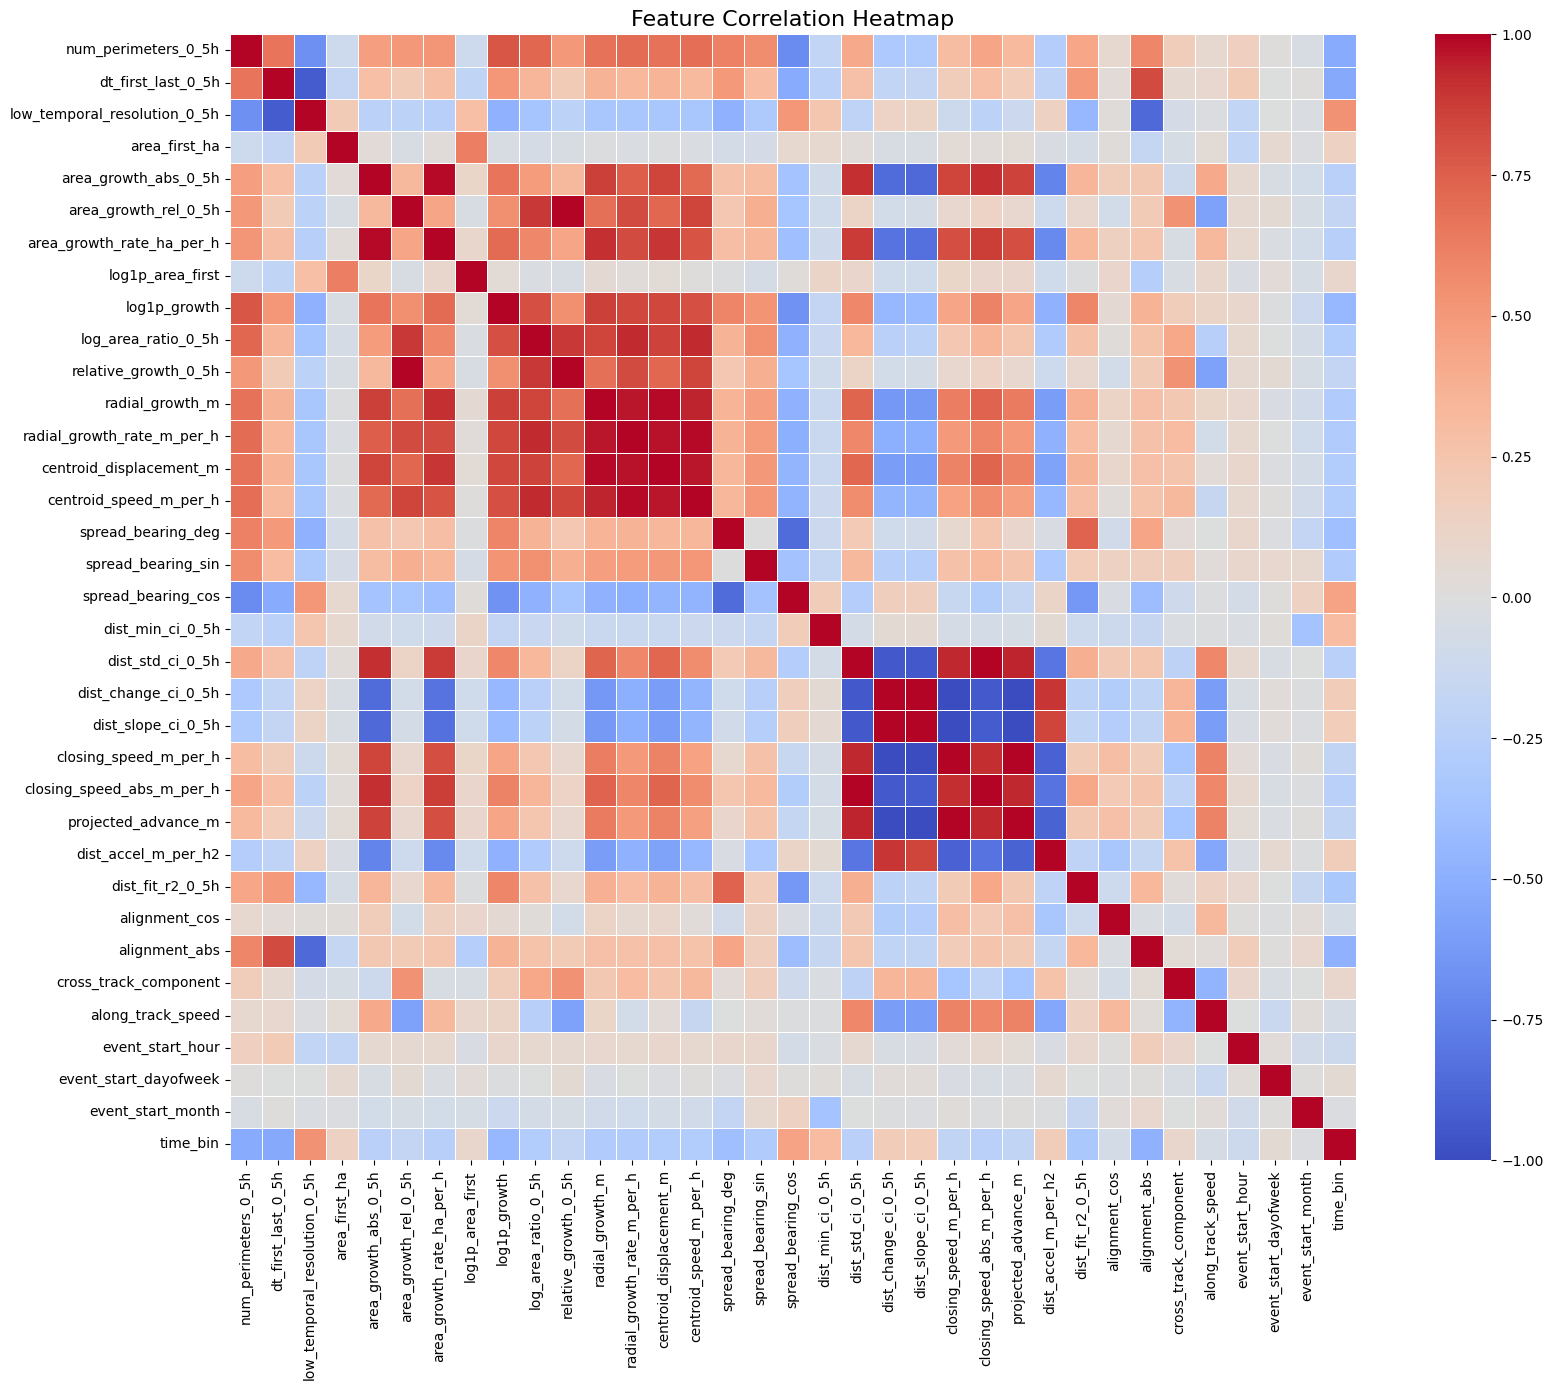

In [302]:
# ===============================
# Select only feature columns
# ===============================

exclude_cols = [
    "event_id",
    "time_to_hit_hours",
    "event"
]

feature_cols = [c for c in train.columns if c not in exclude_cols]

X_feat = train[feature_cols].copy()

# ===============================
# Compute correlation matrix
# ===============================

corr_matrix = X_feat.corr(method="pearson")

# ===============================
# Plot heatmap
# ===============================

plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [303]:
threshold = 0.85

high_corr = (
    corr_matrix
    .abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
)

high_corr_pairs = (
    high_corr.stack()
    .reset_index()
)

high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] > threshold]

print(high_corr_pairs.sort_values("Correlation", ascending=False))


                        Feature_1                     Feature_2  Correlation
164          area_growth_rel_0_5h          relative_growth_0_5h     1.000000
493           dist_change_ci_0_5h           projected_advance_m     1.000000
491           dist_change_ci_0_5h         closing_speed_m_per_h     0.998166
518         closing_speed_m_per_h           projected_advance_m     0.998166
478              dist_std_ci_0_5h     closing_speed_abs_m_per_h     0.996875
504            dist_slope_ci_0_5h         closing_speed_m_per_h     0.993135
506            dist_slope_ci_0_5h           projected_advance_m     0.993057
490           dist_change_ci_0_5h            dist_slope_ci_0_5h     0.993057
131          area_growth_abs_0_5h     area_growth_rate_ha_per_h     0.991339
320               radial_growth_m       centroid_displacement_m     0.989127
343    radial_growth_rate_m_per_h        centroid_speed_m_per_h     0.989008
342    radial_growth_rate_m_per_h       centroid_displacement_m     0.969151

In [304]:

    # gbsa = RandomSurvivalForest(
    #     n_estimators=300,
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     n_jobs=-1,
    #     random_state=42
    # )

    # gbsa = ComponentwiseGradientBoostingSurvivalAnalysis(
    #     n_estimators=600,        # boosting rounds
    #     learning_rate=0.02,     # small = better generalization
    #     subsample=0.75,          # stochastic boosting
    #     dropout_rate=0.15,       # regularization (like dropout)
    #     random_state=42
    # )

    # gbsa = ExtraSurvivalTrees(
    #     n_estimators=400,               
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     bootstrap=False,        # ExtraTrees usually works better without bootstrap
    #     n_jobs=-1,
    #     random_state=42
    # )


    # -------------------------
    # RSF
    # -------------------------

    # gbsa = CoxnetSurvivalAnalysis(
    #     l1_ratio=0.7,
    #     alphas=[0.01],
    #     fit_baseline_model=True   # ✅ REQUIRED
    # )

    # rsf = RandomSurvivalForest(
    #     n_estimators=300,
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     n_jobs=-1,
    #     random_state=42
    # )

    # rsf= RandomSurvivalForest(n_estimators=100)

In [305]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest

from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sksurv.ensemble import ExtraSurvivalTrees, ComponentwiseGradientBoostingSurvivalAnalysis

from sklearn.preprocessing import MinMaxScaler

from sksurv.linear_model import CoxPHSurvivalAnalysis,CoxnetSurvivalAnalysis


In [306]:
# ===============================
# Prepare target
# ===============================

time = train["time_to_hit_hours"].values
event = train["event"].astype(bool).values

y = Surv.from_arrays(event, time)


# ===============================
# Stratified CV
# ===============================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hybrid_scores = []
cindex_scores = []
brier_scores = []


# ===============================
# OOF containers
# ===============================

oof_event_prob_12h = np.zeros(len(X))
oof_event_prob_24h = np.zeros(len(X))
oof_event_prob_48h = np.zeros(len(X))
oof_event_prob_72h = np.zeros(len(X))

oof_risk = np.zeros(len(X))   # optional


# ===============================
# TEST containers (accumulate)
# ===============================

test_event_prob_12h_sum = np.zeros(len(X_test))
test_event_prob_24h_sum = np.zeros(len(X_test))
test_event_prob_48h_sum = np.zeros(len(X_test))
test_event_prob_72h_sum = np.zeros(len(X_test))

test_risk_sum = np.zeros(len(X_test))


# ===============================
# CV loop
# ===============================

for fold, (train_idx, val_idx) in enumerate(skf.split(X,event), 1):   #  so this for all columns and then average them out end 

    print(f"\n===== Fold {fold} =====")

    X_train_df, X_val_df = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    # X_train_df = growth_intensity(X_train_df)
    # X_val_df   = growth_intensity(X_val_df)
    # X_test   = growth_intensity(X_test)

    # -------------------------
    # Scale
    # -------------------------

    scaler = StandardScaler()  # MinMaxScaler

    X_train = scaler.fit_transform(X_train_df)
    X_val   = scaler.transform(X_val_df)
    X_test_scaled = scaler.transform(X_test)



    gbsa = GradientBoostingSurvivalAnalysis(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,random_state=42
    )

    # gbsa =CoxPHSurvivalAnalysis(alpha=1.0)


    gbsa.fit(X_train, y_train)

    # -------------------------
    # Risk OOF
    # -------------------------

    oof_risk[val_idx] = gbsa.predict(X_val)

    # -------------------------
    # Hybrid + event probs (VAL)
    # -------------------------

    metrics = calculate_hybrid_score(
        model=gbsa,
        X_val=X_val,
        y_val=y_val,
        horizons=[24, 48, 72],
        weights=[0.3, 0.4, 0.3]
    )

    # -------------------------
    # SAVE OOF EVENT PROBS
    # -------------------------

    oof_event_prob_12h[val_idx] = metrics["prob_12h"]
    oof_event_prob_24h[val_idx] = metrics["prob_24h"]
    oof_event_prob_48h[val_idx] = metrics["prob_48h"]
    oof_event_prob_72h[val_idx] = metrics["prob_72h"]

    oof_risk[val_idx]=metrics["risk_score"]

    # -------------------------
    # TEST predictions (this fold)
    # -------------------------

    test_surv_fns = gbsa.predict_survival_function(X_test_scaled)

    test_event_probs = extract_event_probs(
        test_surv_fns,
        time_points=[12, 24, 48, 72]
    )

    # accumulate
    test_event_prob_12h_sum += test_event_probs[:, 0]
    test_event_prob_24h_sum += test_event_probs[:, 1]
    test_event_prob_48h_sum += test_event_probs[:, 2]
    test_event_prob_72h_sum += test_event_probs[:, 3]

    test_risk_sum += gbsa.predict(X_test_scaled)

    # -------------------------
    # Logs
    # -------------------------

    print("Hybrid :", round(metrics["hybrid"], 4))
    print("C-index:", round(metrics["c_index"], 4))
    print("WBrier :", round(metrics["weighted_brier"], 4))
    print("Brier each:", metrics["brier_each"])

    hybrid_scores.append(metrics["hybrid"])
    cindex_scores.append(metrics["c_index"])
    brier_scores.append(metrics["weighted_brier"])


# ===============================
# Average TEST predictions
# ===============================

n_folds = skf.n_splits

test_event_prob_12h = test_event_prob_12h_sum / n_folds
test_event_prob_24h = test_event_prob_24h_sum / n_folds
test_event_prob_48h = test_event_prob_48h_sum / n_folds
test_event_prob_72h = test_event_prob_72h_sum / n_folds

test_risk = test_risk_sum / n_folds


# ===============================
# Attach to test dataframe
# ===============================

sub["prob_12h"] = test_event_prob_12h
sub["prob_24h"] = test_event_prob_24h
sub["prob_48h"] = test_event_prob_48h
sub["prob_72h"] = test_event_prob_72h
# test["risk_score"]    = test_risk

# ===============================
# Final CV results
# ===============================

print("\n==============================")
print("MEAN Hybrid :", np.mean(hybrid_scores))
print("MEAN C-index:", np.mean(cindex_scores))
print("MEAN WBrier :", np.mean(brier_scores))
print("STD Hybrid  :", np.std(hybrid_scores))



# # MEAN Hybrid : 0.9703392359042567
# # MEAN C-index: 0.9394916083586804
# # MEAN WBrier : 0.01644035229049621
# # STD Hybrid  : 0.012678479068302198

# ==============================
# MEAN Hybrid : 0.9766021321858019
# MEAN C-index: 0.9403593260636939
# MEAN WBrier : 0.007865236619008975
# STD Hybrid  : 0.008336213863820805


# ==============================
# MEAN Hybrid : 0.9766021321858019
# MEAN C-index: 0.9403593260636939
# MEAN WBrier : 0.007865236619008975
# STD Hybrid  : 0.008336213863820805

# ==============================
# MEAN Hybrid : 0.9784986711482937
# MEAN C-index: 0.9422063248626321
# MEAN WBrier : 0.0059474661578515125
# STD Hybrid  : 0.006671624303532271


===== Fold 1 =====
Hybrid : 0.983
C-index: 0.9472
WBrier : 0.0016
Brier each: {24: np.float64(0.0014987354383370433), 48: np.float64(0.0013185027382096376), 72: np.float64(0.0020729727600643393)}

===== Fold 2 =====
Hybrid : 0.9612
C-index: 0.9327
WBrier : 0.0266
Brier each: {24: np.float64(0.04491076317404778), 48: np.float64(0.023864590013011677), 72: np.float64(0.011919040954714482)}

===== Fold 3 =====
Hybrid : 0.957
C-index: 0.9402
WBrier : 0.0358
Brier each: {24: np.float64(0.05760880746511234), 48: np.float64(0.044258100187764396), 72: np.float64(0.002677351579352667)}

===== Fold 4 =====
Hybrid : 0.9881
C-index: 0.9635
WBrier : 0.0014
Brier each: {24: np.float64(0.0011809224262738123), 48: np.float64(0.0011354130600012972), 72: np.float64(0.001994466319904709)}

===== Fold 5 =====
Hybrid : 0.9638
C-index: 0.9182
WBrier : 0.0166
Brier each: {24: np.float64(0.03976503888093512), 48: np.float64(0.007618619725589251), 72: np.float64(0.005571808937567682)}

MEAN Hybrid : 0.97062246

In [307]:
from sklearn.isotonic import IsotonicRegression
from sksurv.metrics import concordance_index_censored, brier_score
import numpy as np


def calculate_hybrid_score(
    model,
    X_val,
    y_val,
    horizons=[24, 48, 72],
    weights=[0.3, 0.4, 0.3],
    eps=1e-6,
    apply_isotonic=True
):

    # =====================
    # 1. C-index
    # =====================

    risk_preds = model.predict(X_val)

    c_index = concordance_index_censored(
        y_val["event"],
        y_val["time"],
        risk_preds
    )[0]

    # =====================
    # 2. Safe horizons
    # =====================

    min_time = y_val["time"].min()
    max_time = y_val["time"].max()

    safe_horizons = np.clip(
        horizons,
        min_time + eps,
        max_time - eps
    )

    # =====================
    # 3. Event probabilities
    # =====================

    surv_fns = model.predict_survival_function(X_val)

    event_probs = extract_event_probs(
        surv_fns,
        safe_horizons,
        eps=eps
    )

    event_probs_all = extract_event_probs(
        surv_fns,
        [12, 24, 48, 72],
        eps=eps
    )

    iso_models = []   # 🔥 IMPORTANT

    # =====================
    # 4. Isotonic calibration
    # =====================

    if apply_isotonic:

        val_time = y_val["time"]
        val_event = y_val["event"]

        for j, h in enumerate(safe_horizons):

            y_h = ((val_time <= h) & (val_event == 1)).astype(int)
            p_h = event_probs[:, j]

            iso = IsotonicRegression(out_of_bounds="clip")
            iso.fit(p_h, y_h)

            event_probs[:, j] = iso.transform(p_h)
            iso_models.append(iso)

        # Also calibrate full output for saving
        # 0 = 12h
        # 1 = 24h
        # 2 = 48h
        # 3 = 72h
        
        calibration_columns = [1, 2, 3]  # columns for 24,48,72
        
        for j, col_idx in enumerate(calibration_columns):
            event_probs_all[:, col_idx] = iso_models[j].transform(
                event_probs_all[:, col_idx]
            )


    # =====================
    # 5. Brier
    # =====================

    brier_vals = []

    for i, t in enumerate(safe_horizons):

        surv_probs = 1.0 - event_probs[:, i]

        _, bs = brier_score(
            y_val,
            y_val,
            surv_probs,
            t
        )

        brier_vals.append(bs[0])

    brier_vals = np.array(brier_vals)

    weighted_brier = np.average(
        brier_vals,
        weights=weights[:len(brier_vals)]
    )

    # =====================
    # 6. Hybrid
    # =====================

    hybrid = 0.3 * c_index + 0.7 * (1.0 - weighted_brier)

    # =====================
    # 7. Return
    # =====================

    return {
        "hybrid": hybrid,
        "c_index": c_index,
        "weighted_brier": weighted_brier,
        "brier_each": dict(zip(horizons[:len(brier_vals)], brier_vals)),
        "prob_12h": event_probs_all[:, 0],
        "prob_24h": event_probs_all[:, 1],
        "prob_48h": event_probs_all[:, 2],
        "prob_72h": event_probs_all[:, 3],
        "risk_score": risk_preds,
        "iso_models": iso_models   # 🔥 NOW IT EXISTS
    }


In [308]:

    # gbsa = RandomSurvivalForest(
    #     n_estimators=300,
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     n_jobs=-1,
    #     random_state=42
    # )

    # gbsa = ComponentwiseGradientBoostingSurvivalAnalysis(
    #     n_estimators=600,        # boosting rounds
    #     learning_rate=0.02,     # small = better generalization
    #     subsample=0.75,          # stochastic boosting
    #     dropout_rate=0.15,       # regularization (like dropout)
    #     random_state=42
    # )

    # gbsa = ExtraSurvivalTrees(
    #     n_estimators=400,               
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     bootstrap=False,        # ExtraTrees usually works better without bootstrap
    #     n_jobs=-1,
    #     random_state=42
    # )


    # -------------------------
    # RSF
    # -------------------------

    # gbsa = CoxnetSurvivalAnalysis(
    #     l1_ratio=0.7,
    #     alphas=[0.01],
    #     fit_baseline_model=True   # ✅ REQUIRED
    # )

    # rsf = RandomSurvivalForest(
    #     n_estimators=300,
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     n_jobs=-1,
    #     random_state=42
    # )

    # rsf= RandomSurvivalForest(n_estimators=100)

In [309]:
# MEAN Hybrid : 0.9703392359042567
# MEAN C-index: 0.9394916083586804
# MEAN WBrier : 0.01644035229049621
# STD Hybrid  : 0.012678479068302198


# ===============================
# Prepare target
# ===============================

time = train["time_to_hit_hours"].values
event = train["event"].astype(bool).values

y = Surv.from_arrays(event, time)


# ===============================
# Stratified CV
# ===============================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hybrid_scores = []
cindex_scores = []
brier_scores = []


# ===============================
# OOF containers
# ===============================

oof_event_prob_12h = np.zeros(len(X))
oof_event_prob_24h = np.zeros(len(X))
oof_event_prob_48h = np.zeros(len(X))
oof_event_prob_72h = np.zeros(len(X))

oof_risk = np.zeros(len(X))


# ===============================
# TEST containers (accumulate)
# ===============================

test_event_prob_12h_sum = np.zeros(len(X_test))
test_event_prob_24h_sum = np.zeros(len(X_test))
test_event_prob_48h_sum = np.zeros(len(X_test))
test_event_prob_72h_sum = np.zeros(len(X_test))

test_risk_sum = np.zeros(len(X_test))


# ===============================
# CV loop
# ===============================

for fold, (train_idx, val_idx) in enumerate(skf.split(X, event), 1):

    print(f"\n===== Fold {fold} =====")

    X_train_df, X_val_df = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # X_train_df = growth_intensity(X_train_df)
    # X_val_df   = growth_intensity(X_val_df)
    # X_test   = growth_intensity(X_test)

    # # engineer_features

    # X_train_df = engineer_features(X_train_df)
    # X_val_df   = engineer_features(X_val_df)
    # X_test   = engineer_features(X_test)


    # -------------------------
    # Scaling
    # -------------------------

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train_df)
    X_val   = scaler.transform(X_val_df)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------
    # Model
    # -------------------------

    gbsa = GradientBoostingSurvivalAnalysis(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )

    # gbsa = ExtraSurvivalTrees(
    #     n_estimators=400,               
    #     min_samples_split=10,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     bootstrap=False,        # ExtraTrees usually works better without bootstrap
    #     n_jobs=-1,
    #     random_state=42
    # )


    gbsa.fit(X_train, y_train)

    # -------------------------
    # Hybrid + calibrated VAL
    # -------------------------

    metrics = calculate_hybrid_score(
        model=gbsa,
        X_val=X_val,
        y_val=y_val,
        horizons=[24, 48, 72],
        weights=[0.3, 0.4, 0.3],
        apply_isotonic=True
    )

    # -------------------------
    # SAVE OOF (already calibrated)
    # -------------------------

    oof_event_prob_12h[val_idx] = metrics["prob_12h"]
    oof_event_prob_24h[val_idx] = metrics["prob_24h"]
    oof_event_prob_48h[val_idx] = metrics["prob_48h"]
    oof_event_prob_72h[val_idx] = metrics["prob_72h"]

    oof_risk[val_idx] = metrics["risk_score"]

    # -------------------------
    # TEST predictions (calibrated)
    # -------------------------

    test_surv_fns = gbsa.predict_survival_function(X_test_scaled)

    test_event_probs = extract_event_probs(
        test_surv_fns,
        time_points=[12, 24, 48, 72]
    )

    # Apply fold isotonic models
    iso_models = metrics["iso_models"]

    # iso_models correspond to [24,48,72]
    horizon_map = {24:1, 48:2, 72:3}

    for j, iso in enumerate(iso_models):
        horizon = [24,48,72][j]
        col_idx = horizon_map[horizon]
        test_event_probs[:, col_idx] = iso.transform(
            test_event_probs[:, col_idx]
        )

    # Accumulate calibrated
    test_event_prob_12h_sum += test_event_probs[:, 0]
    test_event_prob_24h_sum += test_event_probs[:, 1]
    test_event_prob_48h_sum += test_event_probs[:, 2]
    test_event_prob_72h_sum += test_event_probs[:, 3]

    test_risk_sum += gbsa.predict(X_test_scaled)

    # -------------------------
    # Logs
    # -------------------------

    print("Hybrid :", round(metrics["hybrid"], 4))
    print("C-index:", round(metrics["c_index"], 4))
    print("WBrier :", round(metrics["weighted_brier"], 4))
    print("Brier each:", metrics["brier_each"])

    hybrid_scores.append(metrics["hybrid"])
    cindex_scores.append(metrics["c_index"])
    brier_scores.append(metrics["weighted_brier"])


# ===============================
# Average TEST predictions
# ===============================

n_folds = skf.n_splits

test_event_prob_12h = test_event_prob_12h_sum / n_folds
test_event_prob_24h = test_event_prob_24h_sum / n_folds
test_event_prob_48h = test_event_prob_48h_sum / n_folds
test_event_prob_72h = test_event_prob_72h_sum / n_folds

test_risk = test_risk_sum / n_folds


# ===============================
# Attach to submission
# ===============================

sub["prob_12h"] = test_event_prob_12h
sub["prob_24h"] = test_event_prob_24h
sub["prob_48h"] = test_event_prob_48h
sub["prob_72h"] = test_event_prob_72h


# ===============================
# Final CV results
# ===============================

print("\n==============================")
print("MEAN Hybrid :", np.mean(hybrid_scores))
print("MEAN C-index:", np.mean(cindex_scores))
print("MEAN WBrier :", np.mean(brier_scores))
print("STD Hybrid  :", np.std(hybrid_scores))



===== Fold 1 =====
Hybrid : 0.9841
C-index: 0.9472
WBrier : 0.0
Brier each: {24: np.float64(0.0), 48: np.float64(0.0), 72: np.float64(0.0)}

===== Fold 2 =====
Hybrid : 0.9689
C-index: 0.9327
WBrier : 0.0155
Brier each: {24: np.float64(0.03254968287526428), 48: np.float64(0.014446047779381112), 72: np.float64(0.0)}

===== Fold 3 =====
Hybrid : 0.9711
C-index: 0.9402
WBrier : 0.0156
Brier each: {24: np.float64(0.028856304985337245), 48: np.float64(0.017392630852030185), 72: np.float64(0.0)}

===== Fold 4 =====
Hybrid : 0.989
C-index: 0.9635
WBrier : 0.0
Brier each: {24: np.float64(0.0), 48: np.float64(0.0), 72: np.float64(0.0)}

===== Fold 5 =====
Hybrid : 0.9698
C-index: 0.9182
WBrier : 0.0082
Brier each: {24: np.float64(0.027229717614332995), 48: np.float64(0.0), 72: np.float64(0.0)}

MEAN Hybrid : 0.9766021321858019
MEAN C-index: 0.9403593260636939
MEAN WBrier : 0.007865236619008975
STD Hybrid  : 0.008336213863820805


In [310]:
# every row must be valid at its own bin
assert np.all(valid_mask[np.arange(len(train)), train["time_bin"]] == True)

# after the time_bin, everything must be False
for i in range(len(train)):
    tb = train.loc[i, "time_bin"]
    assert not valid_mask[i, tb+1:].any()

In [311]:
print("bins are :" )
bins

bins are :


array([ 0.        ,  0.54202654,  1.81803431,  3.53484561,  7.79878526,
       18.34946206, 66.99447413])

   bin_start_time  bin_end_time  risk_set_from_KM  risk_set_from_mask  \
0        0.000000      0.542027               209                 221   
1        0.542027      1.818034               198                 208   
2        1.818034      3.534846               186                 195   
3        3.534846      7.798785               174                 182   
4        7.798785     18.349462               163                 171   
5       18.349462     66.994474                99                 149   

   difference  
0          12  
1          10  
2           9  
3           8  
4           8  
5          50  


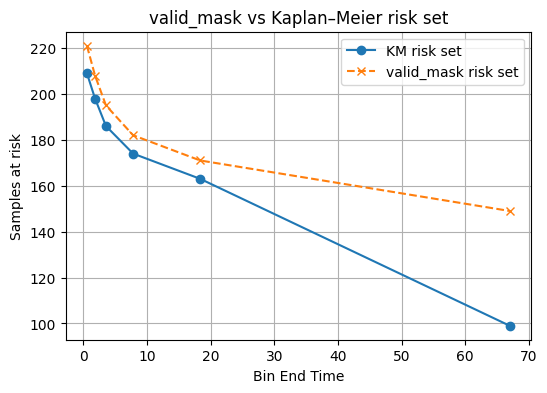

In [312]:
from lifelines import KaplanMeierFitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# 1. Fit KM
# =====================

kmf = KaplanMeierFitter()
kmf.fit(
    durations=train["time_to_hit_hours"].values,
    event_observed=train["event"].values
)

# =====================
# 2. Bin boundaries
# =====================

bin_start_times = bins[:-1]   # left edge
bin_end_times   = bins[1:]    # right edge

N = len(train)

# =====================
# 3. KM risk set at bin END
# =====================

km_survival = kmf.predict(bin_end_times).values
km_risk_set = np.round(km_survival * N).astype(int)

# =====================
# 4. Mask risk set
# =====================

mask_risk_set = valid_mask.sum(axis=0)

# =====================
# 5. Combine into table
# =====================

check_df = pd.DataFrame({
    "bin_start_time": bin_start_times,
    "bin_end_time": bin_end_times,
    "risk_set_from_KM": km_risk_set,
    "risk_set_from_mask": mask_risk_set,
    "difference": mask_risk_set - km_risk_set
})

print(check_df)


plt.figure(figsize=(6,4))

plt.plot(bin_end_times, km_risk_set, marker="o", label="KM risk set")
plt.plot(bin_end_times, mask_risk_set, marker="x", linestyle="--", label="valid_mask risk set")

plt.xlabel("Bin End Time")
plt.ylabel("Samples at risk")
plt.legend()
plt.title("valid_mask vs Kaplan–Meier risk set")
plt.grid(True)
plt.show()


# That dip at ~48h (−19) corresponds to:

# wide bin

# few events

# heavy censoring


In [313]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# from sksurv.util import Surv
# import numpy as np

# # ===============================
# # Prepare survival target
# # ===============================

# time = train["time_to_hit_hours"].values
# event = train["event"].astype(bool).values

# y = Surv.from_arrays(event, time)

# # ===============================
# # Bin-wise Stratified CV
# # ===============================

# skf = StratifiedKFold(
#     n_splits=5,
#     shuffle=True,
#     random_state=42
# )

# hybrid_scores = []
# cindex_scores = []
# brier_scores = []

# # ===============================
# # OOF containers
# # ===============================

# oof_event_prob_12h = np.zeros(len(X))
# oof_event_prob_24h = np.zeros(len(X))
# oof_event_prob_48h = np.zeros(len(X))
# oof_event_prob_72h = np.zeros(len(X))
# oof_risk = np.zeros(len(X))

# # ===============================
# # TEST containers
# # ===============================

# test_event_prob_12h_sum = np.zeros(len(X_test))
# test_event_prob_24h_sum = np.zeros(len(X_test))
# test_event_prob_48h_sum = np.zeros(len(X_test))
# test_event_prob_72h_sum = np.zeros(len(X_test))
# test_risk_sum = np.zeros(len(X_test))

# # ===============================
# # CV LOOP
# # ===============================

# for fold, (train_idx, val_idx) in enumerate(
#     skf.split(X, train["time_bin"]), 1
# ):

#     print(f"\n===== Fold {fold} =====")

#     X_train_df, X_val_df = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

    
#     # X_train_df = growth_intensity(X_train_df)
#     # X_val_df   = growth_intensity(X_val_df)
#     # X_test   = growth_intensity(X_test)

#     # -------------------------
#     # Scale
#     # -------------------------

#     scaler = StandardScaler()

#     X_train = scaler.fit_transform(X_train_df)
#     X_val   = scaler.transform(X_val_df)
#     X_test_scaled = scaler.transform(X_test)

#     # -------------------------
#     # Model
#     # -------------------------

#     gbsa = GradientBoostingSurvivalAnalysis(
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=3
#     )

#     gbsa.fit(X_train, y_train)

#     # -------------------------
#     # OOF Risk
#     # -------------------------

#     oof_risk[val_idx] = gbsa.predict(X_val)

#     # -------------------------
#     # Hybrid Score (VAL)
#     # -------------------------

#     metrics = calculate_hybrid_score(
#         model=gbsa,
#         X_val=X_val,
#         y_val=y_val,
#         horizons=[24, 48, 72],
#         weights=[0.3, 0.4, 0.3]
#     )

#     # -------------------------
#     # Save OOF Event Probs
#     # -------------------------

#     oof_event_prob_12h[val_idx] = metrics["prob_12h"]
#     oof_event_prob_24h[val_idx] = metrics["prob_24h"]
#     oof_event_prob_48h[val_idx] = metrics["prob_48h"]
#     oof_event_prob_72h[val_idx] = metrics["prob_72h"]

#     # -------------------------
#     # TEST Predictions
#     # -------------------------

#     test_surv_fns = gbsa.predict_survival_function(X_test_scaled)

#     test_event_probs = extract_event_probs(
#         test_surv_fns,
#         time_points=[12, 24, 48, 72]
#     )

#     test_event_prob_12h_sum += test_event_probs[:, 0]
#     test_event_prob_24h_sum += test_event_probs[:, 1]
#     test_event_prob_48h_sum += test_event_probs[:, 2]
#     test_event_prob_72h_sum += test_event_probs[:, 3]

#     test_risk_sum += gbsa.predict(X_test_scaled)

#     # -------------------------
#     # Logs
#     # -------------------------

#     print("Hybrid :", round(metrics["hybrid"], 4))
#     print("C-index:", round(metrics["c_index"], 4))
#     print("WBrier :", round(metrics["weighted_brier"], 4))
#     print("Brier each:", metrics["brier_each"])

#     hybrid_scores.append(metrics["hybrid"])
#     cindex_scores.append(metrics["c_index"])
#     brier_scores.append(metrics["weighted_brier"])


# # ===============================
# # Average TEST predictions
# # ===============================

# n_folds = skf.n_splits

# test_event_prob_12h = test_event_prob_12h_sum / n_folds
# test_event_prob_24h = test_event_prob_24h_sum / n_folds
# test_event_prob_48h = test_event_prob_48h_sum / n_folds
# test_event_prob_72h = test_event_prob_72h_sum / n_folds
# test_risk = test_risk_sum / n_folds


# # ===============================
# # Attach to submission
# # ===============================

# sub["prob_12h"] = test_event_prob_12h
# sub["prob_24h"] = test_event_prob_24h
# sub["prob_48h"] = test_event_prob_48h
# sub["prob_72h"] = test_event_prob_72h

# # ===============================
# # Final CV results
# # ===============================

# print("\n==============================")
# print("MEAN Hybrid :", np.mean(hybrid_scores))
# print("MEAN C-index:", np.mean(cindex_scores))
# print("MEAN WBrier :", np.mean(brier_scores))
# print("STD Hybrid  :", np.std(hybrid_scores))


In [314]:
# ==============================
# MEAN Hybrid : 0.9713275768387781
# MEAN C-index: 0.9495849824044595
# MEAN WBrier : 0.019354168403656762
# STD Hybrid  : 0.01230232481620914

# ==============================
# MEAN Hybrid : 0.9704723985666519
# MEAN C-index: 0.9399400388519539
# MEAN WBrier : 0.01644230441276327
# STD Hybrid  : 0.012577609177353035

# ==============================
# MEAN Hybrid : 0.970465575446066
# MEAN C-index: 0.9399400388519539
# MEAN WBrier : 0.016452051727886035
# STD Hybrid  : 0.01258213600136669

# ==============================
# MEAN Hybrid : 0.9707691956538895
# MEAN C-index: 0.9423902659465313
# MEAN WBrier : 0.017068405900099892
# STD Hybrid  : 0.012529113203433261


# ==============================with encodings
# MEAN Hybrid : 0.9713271444006075
# MEAN C-index: 0.9495713747059042
# MEAN WBrier : 0.01934895430166241
# STD Hybrid  : 0.012471830120557583



# ==============================without encodings
# MEAN Hybrid : 0.9713397099108644
# MEAN C-index: 0.9495849824044595
# MEAN WBrier : 0.019336835443533512
# STD Hybrid  : 0.012291622216285308

In [315]:
# def make_discrete_targets(time, event, bins):
#     Y = np.zeros((len(time), len(bins)-1))
    
#     for i, t in enumerate(bins[1:]):
#         Y[:, i] = ((time <= t) & (event == 1)).astype(int)
        
#     return Y

# # create stratification label

# time_bins = pd.qcut(
#     train["time_to_hit_hours"],
#     q=5,
#     duplicates="drop"
# )

# strat_labels = (
#     train["event"].astype(str) + "_" + time_bins.astype(str)
# )


# bins = [12, 24, 36, 48, 60, 72]

# Y_disc = make_discrete_targets(
#     train["time_to_hit_hours"].values,
#     train["event"].values,
#     bins
# )



# models = {}

# for i, t in enumerate(bins):
    
#     y_bin = Y_disc[:, i]

#     model = lgb.LGBMClassifier(
#         n_estimators=600,
#         learning_rate=0.03,
#         num_leaves=64
#     )

#     model.fit(X_train, y_bin)

#     models[t] = model


# prob_12h = models[12].predict_proba(X_test)[:,1]
# prob_24h = models[24].predict_proba(X_test)[:,1]


# stack_X = np.column_stack([
#     gbm_pred_12h,
#     cat_pred_12h,
#     rsf_pred_12h,
#     nn_pred_12h
# ])

# meta = LogisticRegression()
# meta.fit(stack_X_train, y_12h)

# final_12h = meta.predict_proba(stack_X_test)[:,1]


# from sklearn.isotonic import IsotonicRegression

# iso = IsotonicRegression(out_of_bounds="clip")

# calibrated_prob = iso.fit_transform(
#     raw_prob_oof,
#     y_true_binary
# )


# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression()
# lr.fit(raw_prob_oof.reshape(-1,1), y_true)


In [316]:
# df=pd.DataFrame()
train_with_oof = attach_survival_predictions(
    base_df=train,
    oof_prob_12h=oof_event_prob_12h,
    oof_prob_24h=oof_event_prob_24h,
    oof_prob_48h=oof_event_prob_48h,
    oof_prob_72h=oof_event_prob_72h,
    risk_scores=oof_risk
)

train_with_oof
# attach_survival_predictions(base_df, event_probs, risk_scores, index)

,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,...,event_start_dayofweek,event_start_month,time_to_hit_hours,event,time_bin,prob_12h,prob_24h,prob_48h,prob_72h,risk_score
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,...,4,5,18.892512,0,5,0.020974,0.000000,0.0,0.000000,-1.309998
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,...,4,6,22.048108,1,5,0.994820,0.923077,1.0,1.000000,4.522606
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,...,4,8,0.888895,1,1,1.000000,1.000000,1.0,1.000000,5.418506
3,12044083,1,0.000000,1,67.631125,0.000000,0.000000,0.000000,4.228746,0.000000,...,5,8,60.953021,0,5,0.009610,0.000000,0.0,0.000000,-1.778208
4,12052347,2,4.975273,0,35.632874,0.000000,0.000000,0.000000,3.600946,0.000000,...,5,7,44.990274,0,5,0.010445,0.000000,0.0,0.094520,-1.566729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,97075632,1,0.000000,1,51.295195,0.000000,0.000000,0.000000,3.956904,0.000000,...,6,6,66.340624,0,5,0.008426,0.000000,0.0,0.058465,-1.779012
217,97362560,2,1.127102,0,1.176991,0.000000,0.000000,0.000000,0.777943,0.000000,...,1,7,5.694898,1,3,0.446820,0.800000,1.0,1.000000,2.185013
218,97805715,2,3.710653,0,71.946930,0.000000,0.000000,0.000000,4.289732,0.000000,...,1,9,44.011253,0,5,0.011341,0.000000,0.0,0.107944,-1.483982
219,99071478,1,0.000000,1,20.223659,0.000000,0.000000,0.000000,3.055117,0.000000,...,0,8,22.975783,1,5,0.398343,0.800000,1.0,1.000000,2.032001


In [317]:
train_with_oof.set_index("event_id",inplace=True)
train_with_oof.iloc[:,-7:]

,event,time_bin,prob_12h,prob_24h,prob_48h,prob_72h,risk_score
event_id,,,,,,,
10892457,0,5,0.020974,0.000000,0.0,0.000000,-1.309998
11757157,1,5,0.994820,0.923077,1.0,1.000000,4.522606
11945086,1,1,1.000000,1.000000,1.0,1.000000,5.418506
12044083,0,5,0.009610,0.000000,0.0,0.000000,-1.778208
12052347,0,5,0.010445,0.000000,0.0,0.094520,-1.566729
...,...,...,...,...,...,...,...
97075632,0,5,0.008426,0.000000,0.0,0.058465,-1.779012
97362560,1,3,0.446820,0.800000,1.0,1.000000,2.185013
97805715,0,5,0.011341,0.000000,0.0,0.107944,-1.483982


In [318]:
# import pandas as pd

# # Initialize a list to store the probabilities
# submission_data = []

# for fn in surv_funcs:
#     # fn(t) gives the probability of survival at time t
#     # 1 - fn(t) gives the probability of the event having occurred
#     probs = [1 - fn(t) for t in time_points]
#     submission_data.append(probs)

# # Create the DataFrame
# submission_df = pd.DataFrame(submission_data, columns=['prob_12h', 'prob_24h', 'prob_48h', 'prob_72h'])

# # Add the event_id from your original test set
# submission_df['event_id'] = test['event_id'].values

# # Reorder columns to match the required schema
# submission_df = sub[['event_id', 'prob_12h', 'prob_24h', 'prob_48h', 'prob_72h']]

from datetime import datetime

time = datetime.now().strftime("%Y%m%d_%H%M%S")

sub.to_csv("submission_surv_{}.csv".format(time), index=False)

In [319]:
sub

,event_id,prob_12h,prob_24h,prob_48h,prob_72h
0,10662602,0.010510,0.000000,0.000000,0.029478
1,13353600,0.697239,0.864615,1.000000,1.000000
2,13942327,0.010273,0.000000,0.000000,0.026992
3,16112781,0.896515,0.978596,1.000000,1.000000
4,17132808,0.013564,0.000476,0.000653,0.087942
...,...,...,...,...,...
90,94627327,0.010933,0.000000,0.000000,0.031586
91,96570675,0.010169,0.000000,0.000000,0.026249
92,97225766,0.010139,0.000000,0.000000,0.025503
93,98446281,0.010471,0.000000,0.000000,0.030153
